# REINFORCEMENT LEARNING

### Author: Hyungjoo Kim

##### All data was provided by University College London, Department of Computer Science, Reinforcement Learning Module

##### Supervisor: Prof. Hado Van Hasselt, Matteo Hessel, and Diana Borsa

**Context**

In this assignment, we will take a first look at learning algorithms for sequential decision problems.

**Background reading**

* Sutton and Barto (2018), Chapters 3 - 6

**Overview of this assignment**

You will use Python to implement several reinforcement learning algorithms.

You will then run these algorithms on a few problems, to understand their properties.

# Setup

### Import Useful Libraries

In [12]:
import matplotlib.collections as mcoll
import matplotlib.path as mpa
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

### Set options

In [13]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-colorblind')

### Some grid worlds

In [21]:
W = -100  # wall
G = 100  # goal

GRID_LAYOUT = np.array([
  [W, W, W, W, W, W, W, W, W, W, W, W],
  [W, W, 0, W, W, W, W, W, W, 0, W, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, G, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, W, 0, 0, 0, 0, 0, 0, 0, 0, W, W],
  [W, W, W, W, W, W, W, W, W, W, W, W]
])

class Grid(object):

  def __init__(self, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = GRID_LAYOUT
    self._start_state = (2, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy

  @property
  def number_of_states(self):
      return self._number_of_states

  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def obs_to_state(self, obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]
    s = np.copy(grid._layout)
    s[y, x] = 4
    return s

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    reward = self._layout[new_y, new_x]
    if self._layout[new_y, new_x] == W:  # wall
      discount = 0.9
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = -1.
      discount = 0.9
    else:  # a goal
      discount = 0.
      new_state = self._start_state

    if self._noisy:
      width = self._layout.shape[1]
      reward += 10*np.random.normal(0, width - new_x + new_y)

    self._state = new_state
    return reward, discount, self.get_obs()

  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != W, interpolation="nearest", cmap='pink')
    plt.gca().grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    plt.text(9, 2, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

In [22]:
SMALL_GRID_LAYOUT = np.array([
  [W, W, W, W, W],
  [W, W, 3, W, W],
  [W, W, 0, W, W],
  [W, 1, 0, W, W],
  [W, W, 0, W, W],
  [W, W, 0, 4, W],
  [W, W, W, W, W]
])


def plot_small_grid(version=1):
  plt.imshow(SMALL_GRID_LAYOUT < -1, interpolation='nearest', cmap='pink_r',
             vmin=-0.2, vmax=1.2)
  if version == 1:
    plt.text(2, 1, '$+3$', ha='center', va='center', fontsize=12)
    plt.text(1, 3, '$+1$', ha='center', va='center', fontsize=12)
    plt.text(3, 5, '$+4$', ha='center', va='center', fontsize=12)
  else:
    plt.text(2, 1, '$+2$', ha='center', va='center', fontsize=12)
    plt.text(1, 3, '$+1$', ha='center', va='center', fontsize=12)
    plt.text(3, 5, '$+5$', ha='center', va='center', fontsize=12)
  plt.text(2, 3, '$S$', ha='center', va='center', fontsize=12)
  h, w = SMALL_GRID_LAYOUT.shape
  for r in np.arange(0.5, h):
    plt.plot([-0.5, w - 0.5], [r, r], '-k', lw=3, alpha=0.4)
  for c in np.arange(0.5, w):
    plt.plot([c, c], [-0.5, h - 0.5], '-k', lw=3, alpha=0.4)
  plt.xticks([]); plt.yticks([]);

# Section 1: Tabular RL 

In this section, observations will be states in the environment, so the agent state, environment state, and observation will all be the same, and we will use the word `state` interchangably with `observation`.  You will implement agents, which should be in pure Python - so you cannot use JAX/TensorFlow/PyTorch to compute gradients. Using `numpy` is fine.

## Q1: A small grid world

Consider the grid MDP below:

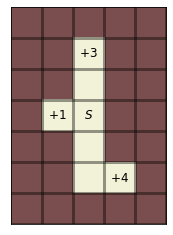

In [23]:
plot_small_grid()

The agent starts at the state marked $S$, and  can move up, left, right, or down.  Whenever it enters a cell with a positive number, the agent receives that reward and the episode terminates.
### Task 1
Use the code below to plot the value of the optimal policy from the starting state, $v_*(S)$, as a function of the discount factor $\gamma$.

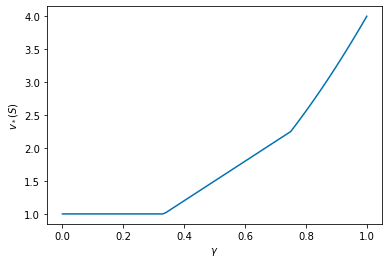

In [24]:
def v(discount):    # v(s) = R + (r*R) + (r**2*R) + (r**3*R) + ... {r is a discount factor}
  v_1 = 1   # From the starting point, move left one time and get reward +1
  v_3 = 0 + discount * 3  # From the starting point, move upward two times and get reward +3
  v_4 = 0 + 0 + discount**2 * 4   # From the starting point, move downwards two times and then right (3 time steps), then get reward +4
  optimal_v = np.max([v_1, v_3, v_4])  # Optimal value function is maximum value among the three cases.
  return optimal_v  

# Don't change this function
def plot_v():
  discounts = np.arange(0, 1.001, 0.01)
  plt.plot(discounts, [v(g) for g in discounts])
  plt.xlabel('$\gamma$')
  plt.ylabel('$v_*(S)$')

plot_v()

### Task 2

Specify the optimal policy, as a function of $\gamma$.

### Answer

>The optimal value function can be provided when the optimal policy is applied and the above figure shows the relation between a state-value function and discount factor. This figure illustrates which direction the system moves depending on the discount factor and can finally find the optimal policy. As shown the above figure, the optimal policy has 3 different cases: 

> - The optimal state-value function ($v_*(S)$) is 1 when the discount factor ($\gamma$) is between 0 and approximately 0.35. This means that the system moves the left hand side (<-) to get reward +1 from the starting point (S) when the discount factor ($\gamma$) is between 0 and 0.35.

> - The optimal state-value function ($v_*(S)$) goes to approximately 3 when the discount factor ($\gamma$) is between 0.35 and 0.79. This means that the system moves upwards to get reward +3 from the starting point (S) when the discount factor ($\gamma$) is between 0.35 and 0.79. 

> - The optimal state-value function ($v_*(S)$) rapidly changes from 2.xx to 4 when the discount factor ($\gamma$) is between 0.79 and 1. This means that the system moves upward before and immediately changes downward to get reward +4 when the discount factor ($\gamma$) is between 0.79 and 1. 

> Therefore, we can prove that the optimal policy depends on the discount factor ($\gamma$) and it can be represented as follow:

$$ \pi_*(S) = move \_ left \implies Reward +1 : \gamma \in [0, 0.35] $$

$$ \pi_*(S) = move \_ upwards \implies Reward +3 : \gamma \in [0.35, 0.79] $$

$$ \pi_*(S) = move \_ downwards/right \implies Reward +4 : \gamma \in [0.79, 1] $$ 

### Task 3
Consider the variation of this problem shown in the next plot.

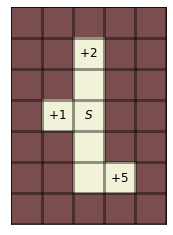

In [25]:
plot_small_grid(version=2)

Suppose a behavioural scientist was doing an experiment where they gave rewards to an animal.  Suppose the setting was as depicted above, where the rewards for instance correspond to food or some other kind of treat (e.g., 5 food pellets at the location marked $+5$). It turns out that, after repeatedly exploring the grid, the animal seems to prefer going up to the reward of $+2$.

Prove that in the MDP depicted above no scalar discount $\gamma \in [0, 1]$ exists for which the optimal policy is to go to $+2$.

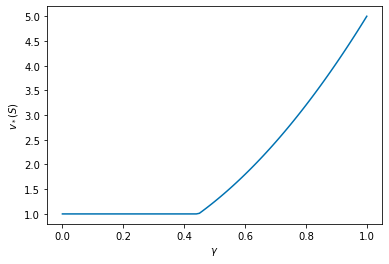

In [26]:
def v(discount):    # v(s) = R + (R * r) + (R * (r**2)) + (R * (r**3)) + ... {r is a discount factor}
  v_1 = 1   # From the starting point, move left one time and get reward +1
  v_2 = 0 + 2 * discount  # From the starting point, move upward two times and get reward +2
  v_5 = 0 + 0 + 5 * (discount**2)  # From the starting point, move downwards two times and then right (3 time steps), then get reward +5
  optimal_v = np.max([v_1, v_2, v_5])  # Optimal value function is maximum value among the three cases.
  return optimal_v  

# Don't change this function
def plot_v():
  discounts = np.arange(0, 1.001, 0.01)
  plt.plot(discounts, [v(g) for g in discounts])
  plt.xlabel('$\gamma$')
  plt.ylabel('$v_*(S)$')

plot_v()

### Answer

> As mentioned the above question 1.2, the optimal policy depends on the discount factor ($\gamma$). The figure shows that the state-value function remains to move the shortest path, which is reward +1 (1 food pellet) when the discount factor ($\gamma$) is between 0 and 0.42. After that, the state-value function directly goes to reward +5 (5 food pellets) when the discount factor ($\gamma$) is after 0.42. This means that the policy does not take moving upward in the Markov decision process (MDP). Therefore, we can prove that the figure represents no scalar discount $\gamma \in [0, 1]$ exists for which the optimal policy is to go to reward +2 (2 food pellets) so that the optimal policy can be represented as follow: 

$$ \pi_*(S) = move \_ left \implies Reward +1 : \gamma \in [0, 0.42] $$

$$ \pi_*(S) = move \_ downwards/right \implies Reward +5 : \gamma \in [0.42, 1] $$

### Task 4
In the same setting as the previous question, now consider the following generalised definition of a Monte Carlo return
\begin{align*}
G_t
& = R_{t+1} + f(R_{t+2} + f(R_{t+3} + f(\ldots))) \\
& = R_{t+1} + f(G_{t+1}) \,,
\end{align*}
In this formulation, we get standard discounting when we define $f(x) = \gamma x$. Consider the following alternative where instead of multiplying with a factor $\gamma$, we raise the value to the power: $f(x) = x^\gamma$.  Does this mathematical model better explain the observed behaviour, in the sense that a $\gamma$ exists for which the optimal policy goes to $+2$?  If so, give such a value for $\gamma$, and prove that the policy of going to $+2$ is optimal with that choice.  If not, prove that no such $\gamma$ exists.

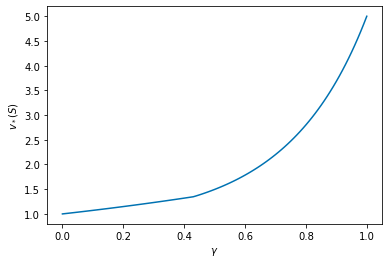

In [27]:
def v(discount):    # v(s) = R + (R^r) + (R^(r^2)) + (R^(r^3)) + ... {r is a discount factor}
  v_1 = 1   # From the starting point, move left one time and get reward +1
  v_2 = 0 + 2**discount  # From the starting point, move upward two times and get reward +2
  v_5 = 0 + 0 + 5**(discount**2)  # From the starting point, move downwards two times and then right (3 time steps), then get reward +5
  optimal_v = np.max([v_1, v_2, v_5])  # Optimal value function is maximum value among the three cases.
  return optimal_v  

# Don't change this function
def plot_v():
  discounts = np.arange(0, 1.001, 0.01)
  plt.plot(discounts, [v(g) for g in discounts])
  plt.xlabel('$\gamma$')
  plt.ylabel('$v_*(S)$')

plot_v()

### Answer

> This figure shows the state-value function using the generalised definition of a Monte Carlo return, which is used the discounting value $f(x) = x^{\gamma}$ and we already proved that the optimal policy depends on the discount factor ($\gamma$) in the above question.

> - When the state-value function goes to get reward +1, the mathematical model of return can be represented as follow:
$$G_t = R_{t+1} = 1$$
> - When the state-value function goes to get reward +2, the mathematical model of return can be represented as follow:
$$ G_t = R_{t+1} + f(R_{t+2}) $$

$$ G_t = R_{t+1} + (R_{t+2})^{\gamma} $$

$$ G_t = 0 + (R_{t+2})^{\gamma} = 2^{\gamma} $$
> - When the state-value function goes to get reward +5, the mathmatical model of return can be represented as follow:
$$ G_t = R_{t+1} + f(R_{t+2} + f(R_{t+3})) $$

$$ G_t = R_{t+1} + f(R_{t+2} + (R_{t+3})^{\gamma}) $$

$$ G_t = 0 + f(0 + (R_{t+3})^{\gamma}) = f((R_{t+3})^{\gamma})$$

$$ G_t =  ((R_{t+3})^{\gamma})^{\gamma}) = ((R_{t+3})^{\gamma^2}) = 5^{\gamma^2}$$

> As shown the figure, the state-value function goes to reward +2 when the discount factor ($\gamma$) is between 0 and approximately 0.42. After that, the state-value function changes to go to reward +5 when the discount factor ($\gamma$) is between 0.42 and 1. Therefore, the optimal policy is moving upward to get reward +2 and the discount factor exists $\gamma \in [0, 0.42]$ when the gerneralised definition of a Monte Carlo return using $f(x) = x^\gamma$ is used.

$$ \pi_*(S) = move \_ upwards \implies Reward +2 : \gamma \in [0, 0.42] $$

$$ \pi_*(S) = move \_ downwards/right \implies Reward +5 : \gamma \in [0.42, 1] $$